# Example

This page was rendered from a Jupyter notebook found [here](https://github.com/benlindsay/pbcluster/docs/example.ipynb).

In this example, we will analyze particle clustering by loading a `.gro` trajectory file (see [here](http://manual.gromacs.org/archive/5.0.3/online/gro.html) for details about this format), then passing that trajectory data to PBCluster. Your trajectories can come from wherever you want, but it's your responsibility to get the particle coordinate data out of them to pass into PBCluster. That data needs to either be in the form of a 3D numpy array with shape `(n_timesteps, n_particles, n_dimensions)`, or a pandas dataframe with columns for `timestep`, `particle_id`, `x0`, `x1`, and `x2` (assuming a 3D simulation box).

Here's a visualization made with [Ovito](https://ovito.org/) of the particle trajectory we'll be analyzing in this example:

![Simulation Visualization](traj.gif)

As the simulation progresses from timestep 0 to 39, the particles start dispersed and aggregate into a single cluster.
At the end of this trajectory, it looks like there is a large cluster on the bottom and a separate, small cluster on top, but those are both part of the same cluster.
Since this box has periodic boundaries (i.e. particles wrap around to the other side of the box if they pass through a face), the cluster wraps across the top and bottom faces of the box.

## Import Libraries

In [1]:
import mdtraj # for loading .gro data
import numpy as np
import pandas as pd
import plotnine as pn # for ggplot2-style plotting

from pbcluster import Trajectory

## Load `.gro` data

We need the particle coordinates and the simulation box size data.

In [2]:
traj_data = mdtraj.load("traj.gro")
# The factor of 10 is because .gro files store coordinates in Angstroms instead of nanometers
particle_coords = traj_data.xyz * 10
n_iterations, n_particles, n_dimensions = particle_coords.shape
print(f"n_iterations: {n_iterations}")
print(f"n_particles: {n_particles}")
print(f"n_dimensions: {n_dimensions}")

n_iterations: 40
n_particles: 34
n_dimensions: 3


So this trajectory file represents a 3D box of 34 particles moving around for 40 iterations.

Now let's get the box lengths data:

In [3]:
box_lengths = traj_data.unitcell_lengths * 10
assert box_lengths.shape == (n_iterations, n_dimensions)
box_lengths[:5, :]

array([[25.33333, 25.33333, 25.33333],
       [25.33333, 25.33333, 25.33333],
       [25.33333, 25.33333, 25.33333],
       [25.33333, 25.33333, 25.33333],
       [25.33333, 25.33333, 25.33333]])

The PBCluster package requires the box size to stay the same for every iteration, so let's double-check that that's true and store just the first row in this array as the box lengths data.

In [4]:
assert np.allclose(box_lengths, box_lengths[0, 0])
box_lengths = box_lengths[0, :]
box_lengths

array([25.33333, 25.33333, 25.33333])

## Compute Cluster and Particle Properties

This package clusters particles based on a choice of a cutoff distance.
Any 2 particles that are within that cutoff distance of each other will be part of the same cluster.
The [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function) (calculated elsewhere) of this trajectory shows a first peak at $r \approx 4.4$, so I chose $r = 4.95$ to capture particle pairs in that peak.

In [5]:
cutoff_distance = 4.95
trajectory = Trajectory(particle_coords, box_lengths, cutoff_distance)

Let's first calculate properties associated with particle clusters. In the dataframe below, each row represents a single cluster with an ID of `cluster_id` at timestep `timestep`.

In [6]:
cluster_properties_df = trajectory.compute_cluster_properties(properties="all")
cluster_properties_df.head()

,asphericity,center_of_mass_x0,center_of_mass_x1,center_of_mass_x2,cluster_id,minimum_node_cuts_x0,minimum_node_cuts_x1,minimum_node_cuts_x2,n_particles,rg,timestep,unwrapped_center_of_mass_x0,unwrapped_center_of_mass_x1,unwrapped_center_of_mass_x2
0,0.997920,2.973333,21.879999,1.625557,0,0,0,0,3,12.698203,0,2.973333,21.879999,26.958887
1,0.000000,16.469999,24.000000,12.610001,1,0,0,0,1,0.000000,0,16.469999,24.000000,12.610001
2,0.000000,10.280000,21.590000,8.280000,2,0,0,0,1,0.000000,0,10.280000,21.590000,8.280000
3,0.921179,12.858000,18.280000,4.704000,3,0,0,0,5,8.104199,0,12.858000,18.280000,4.704000
4,0.000000,13.049999,21.530001,15.700001,4,0,0,0,1,0.000000,0,13.049999,21.530001,15.700001


Now let's calculate properties associated with individual particles. In the dataframe below, each row represents a single particle with an ID of `particle_id` at timestep `timestep`.

In [7]:
particle_properties_df = trajectory.compute_particle_properties(properties="all")
particle_properties_df.head()

,particle_id,x0,x1,x2,coordination_number,dx_from_com_x0,dx_from_com_x1,dx_from_com_x2,distance_from_com,timestep,cluster_id
0,0,2.150000,21.919998,22.560001,1,-0.823333,0.039999,-4.398886,4.475452,0,0
1,3,2.170000,21.500000,2.060000,2,-0.803333,-0.379999,0.434442,0.989184,0,0
2,25,4.600000,22.219999,5.590000,1,1.626667,0.340000,3.964443,4.298657,0,0
3,1,16.469999,24.000000,12.610001,0,0.000000,0.000000,0.000000,0.000000,0,1
4,2,10.280000,21.590000,8.280000,0,0.000000,0.000000,0.000000,0.000000,0,2


## Plot Cluster Properties

The following plot shows how the particle size distribution changes over time. Just like the rows in `cluster_properties_df`, each point represents a single cluster at a given iteration. I added some transparency to each point so overlapping points are seen as a little darker.

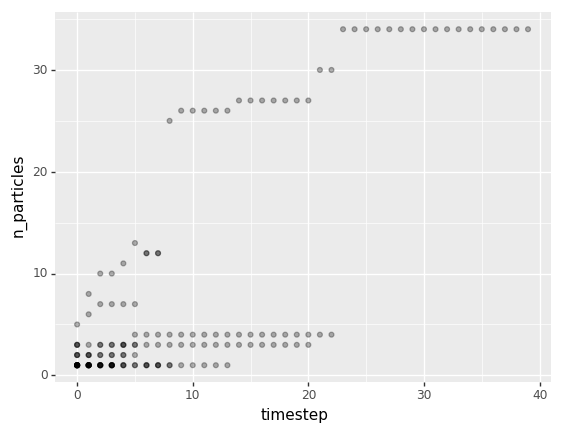

<ggplot: (299276408)>

In [8]:
(
    pn.ggplot(cluster_properties_df)
    + pn.geom_point(pn.aes(x='timestep', y='n_particles'), alpha=0.3)
)

## Plot Particle Properties

The following plot shows how the coordination number distribution changes over time.
Coordination number means the number of neighbors any given particle has.
Here, just like the rows of `particle_properties_df`, each point represents a single particle at a given point in time.
Since there are more total points in this chart, I added a little vertical jitter to each point to reduce the amount of overlap we see.

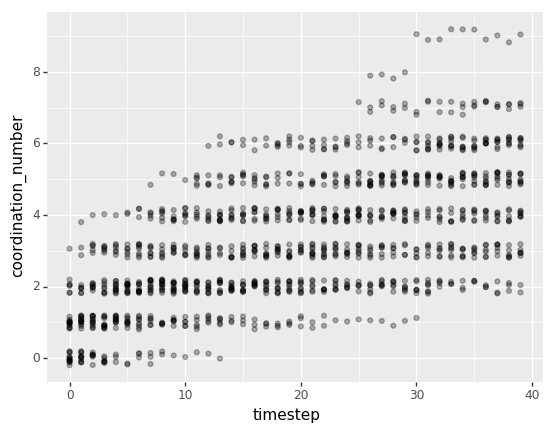

<ggplot: (299356452)>

In [9]:
(
    pn.ggplot(particle_properties_df)
    + pn.geom_jitter(pn.aes(x='timestep', y='coordination_number'), width=0, height=0.2, alpha=0.3)
    + pn.scale_y_continuous(breaks=[0, 2, 4, 6, 8])
)

Overall, both of these plots corroborate what can be seen in the visualization at the top: that particles aggregate over time, forming larger and larger and more densely connected clusters until all particles in the box are part of a single cluster.